
# Spot resources Analytics

Here we perform some initial process and analysis on the dataset.

---




With static dataset, e.g. load the grabbed data.

In [ ]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
%matplotlib inline


# parse the data file and extra the results
filename = 'data1'

df = pd.read_csv(filename, sep="\t", header = None)
df.columns = ["info", "SpotPrice", "TimeStamp", "InstanceType", "OS type", "AvailabilityZone"]
df['TimeStamp'] =pd.to_datetime(df.TimeStamp)

df.index = df.TimeStamp
df = df.drop('info', 1).drop(['OS type'],axis=1)
df = df.drop(['TimeStamp'],axis=1).sort_index()
 

df.head(15)

In [ ]:
print (df['InstanceType'].unique())
print (df['AvailabilityZone'].unique())

In [ ]:
instance_types  = ['c3.xlarge', 'c3.2xlarge', 'c3.4xlarge', 'c3.8xlarge']
region = 'us-east-1'

df1 = df[df.AvailabilityZone == 'us-west-1a']
df2 = df1[df1.InstanceType == 'c3.8xlarge']
df2.to_csv('us-east-1a_c3-8xlarge.csv')

In [ ]:
for k, g in df1.sort_index(ascending=True).groupby(['InstanceType'], as_index=False):
    for key, grp in g.groupby(['AvailabilityZone'], as_index=False):
        plt.figure(figsize=(15,5))
        plt.plot(grp.index, grp['SpotPrice'], label=key)
        
    plt.legend()
    plt.title('Spot Pricing - ' + k)
    plt.show()


In [ ]:
for k, g in df1.sort_index(ascending=True).groupby(['InstanceType'], as_index=False):
    #plt.figure(1, figsize(20,5))
    for key, grp in g.groupby(['AvailabilityZone'], as_index=False):
        plt.figure(figsize=(15,5))
        plt.hist(grp['SpotPrice'], bins=100, label=key,)
        plt.xlim([0, 1])
        #grp.groupby(grp.index.dayofweek).agg(['mean']).plot()
    plt.legend()
    plt.title('Histogram of Spot Pricing - ' + k)
    plt.show()

Now we grad dataset from AWS.

In [ ]:
instance_types  = ['c3.xlarge', 'c3.2xlarge', 'c3.4xlarge', 'c3.8xlarge']
region = 'us-east-1'
number_of_days = 10

end = !date -u "+%Y-%m-%dT%H:%M:%S"
end = end[0]
start = !date -v-{number_of_days}d -u "+%Y-%m-%dT%H:%M:%S"

#start = !date -v-{number_of_days}d" -u "+%Y-%m-%dT%H:%M:%S"
#print(start)
start = start[0]
print ("will process from " + start + " to " + end)


In [ ]:
import sys
import boto as boto
import boto.ec2 as ec2
import datetime, time
#import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.mpl_style', 'default')  # Make the graphs a bit prettier
%pylab inline
%matplotlib inline

ec2 = boto.ec2.connect_to_region(region)


#
# process the output and convert to a dataframe
#

l = []
for instance in instance_types:
    sys.stdout.write("*** processing " + instance + " ***\n")
    sys.stdout.flush()
    prices = ec2.get_spot_price_history(start_time=start, end_time=end, instance_type=instance)
    for price in prices:
        d = {'InstanceType': price.instance_type, 
             'AvailabilityZone': price.availability_zone, 
             'SpotPrice': price.price, 
             'Timestamp': price.timestamp}
        l.append(d)
    next = prices.next_token
    while (next != ''):
        sys.stdout.write(".")
        sys.stdout.flush()
        prices = ec2.get_spot_price_history(start_time=start, end_time=end, instance_type=instance,
                                            next_token=next )
        for price in prices:
            d = {'InstanceType': price.instance_type, 
                 'AvailabilityZone': price.availability_zone, 
                 'SpotPrice': price.price, 
                 'Timestamp': price.timestamp}
            l.append(d)
        next = prices.next_token
        
    sys.stdout.write("\n")

df = pd.DataFrame(l)
df = df.set_index(pd.to_datetime(df['Timestamp']))

## Hypothesis #1
**Problems:** Can we predict future price of a spot instance given previous history and how other vm’s are reacting?

To achieve the goal of prediction, we are expecting to do pattern matching from the collected dataset. In this case, whenever users make a bid, we can based on the resources types, time or day, and the trending price to do pattern matching. We will be able to provide a prediction if we can shoot a pattern.

Expecting tools are supervised and unsupervised learning algorithms, e.g. classification and
clustering methods.



## Hypothesis #2

For each machine type there exists a region that is more favorable to use, as the market volatility is very low and the prices tend to stay cheaper than the other regions.

With in proving this hypothesis users will be able to find the best region they should be bidding in, as long as latency is not an issue for them.

Data Science tools & Techniques: We can use clustering and classification methods.


In [ ]:
print (df.index.min())
print (df.index.max())
print(df.index.max()- df.index.min()) 
#df = df.truncate(before='2015-01-16', after='2015-3-18')

In [ ]:
df = df.resample('H')
df = df.fillna("ffill")

In [ ]:
#Create full time series and fill data
dfSorted = df.groupby(['AvailabilityZone', 'InstanceType'])
dfSorted = dfSorted.resample('H')
dfSorted = dfSorted.fillna("ffill")

dfSorted=dfSorted.drop('InstanceType', axis=1).drop('AvailabilityZone', axis=1)

dfSorted.to_csv("im.csv")
depa = pd.read_csv("im.csv")
depa = depa.groupby(['AvailabilityZone', 'InstanceType'])


In [ ]:
#grouped_prices = [group['SpotPrice'].tolist() for name, group in depa]

#dfer = dataframe
d = {}

count = 0
#need to run through and get rid of rows where timestamp, spotprice data doesnt exist for the others
for name, group in depa:
    if count == 0:
        d['TimeStamp']=group['TimeStamp'].tolist()
    if name[0] =="ap-northeast-1a":
        for a in d['TimeStamp']+group['TimeStamp'].tolist():
            if(a not in d['TimeStamp']):
                group = group[group['TimeStamp'] != a]
                print (a)
            if(a not in group['TimeStamp'].tolist()):
                d['TimeStamp'].remove(a)
                print (a)
    
    
    #seter = set(d['TimeStamp']) - set(group['TimeStamp'].tolist())
    #print(seter)
    #remove = list(seter)
    #print(remove)    
#dfer = pd.DataFrame(d)
    
#for name, group in depa:
     #print(len(group['SpotPrice'].tolist()))
        
'''
for name, group in depa:
    if name[0] =="ap-northeast-1a":
        #group.index = group['TimeStamp']
        #print(group.head(20))
        #group = group.truncate(before='2015-01-18', after='2015-3-17')
        d[name[1]]=group['SpotPrice'].tolist()
        print(len(group['SpotPrice'].tolist()))
'''

In [ ]:
#numpy.corrcoef(grouped_prices)

grouped_prices.corr()
'''
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True
seaborn.heatmap(corr_df, cmap='RdYlGn_r', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5)
# Show the plot we reorient the labels for each column and row to make them easier to read.
plt.yticks(rotation=0) 
plt.xticks(rotation=90) 
plt.show()
'''


# Hypothesis #3

There exists some kind of relation between what kind of virtual machines are turning into hotspots. Say that we establish a line as half price of EC2 instances, it makes sense to pay half price to gain usage of resources but probably not more than 3⁄4. By extracting patterns from the price history, we can study that whether or not there was the case that some resources were becoming hotspot in the spot instances market.

Potential data science method for this one includes: Time Series, Linear Regression


In [ ]:
df = pd.read_csv('us-east-1a_c3-8xlarge.csv')
#df.head(400)
df = df2
df.describe()

df.SpotPrice.plot(label='Spot Price of c3.8xlarge', figsize = (15,5))
plt.legend(loc='best')

In [ ]:
df.head(15)

# Dataset pre-process

Some preprocess work


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


# parse the data file and extra the results
filename = 'aws-spot-price-history/data-1397804701'

df = pd.read_csv(filename, sep="\t", header = None)
df.columns = ["info", "SpotPrice", "TimeStamp", "InstanceType", "OS type", "AvailabilityZone"]
df['TimeStamp'] =pd.to_datetime(df.TimeStamp)

df.index = df.TimeStamp
df = df.drop(['TimeStamp'],axis=1).drop('info', 1).sort_index()


df.head(15)
#df['AvailabilityZone']
#df['InstanceType']

,SpotPrice,InstanceType,OS type,AvailabilityZone
TimeStamp,,,,
2014-02-16 00:54:00,0.0100,m1.small,Linux/UNIX,us-west-1a
2014-02-16 00:55:30,2.7320,c3.8xlarge,Linux/UNIX,us-west-1a
2014-02-16 00:58:09,0.0679,m3.large,Linux/UNIX,us-west-1b
2014-02-16 00:59:56,3.0240,c3.8xlarge,Linux/UNIX,ap-southeast-2a
2014-02-16 01:17:30,0.0224,m3.medium,Linux/UNIX,us-east-1d
2014-02-16 01:17:37,0.0100,m1.small,Linux/UNIX,us-west-1b
2014-02-16 01:24:19,0.7561,c3.2xlarge,Linux/UNIX,ap-southeast-2b
2014-02-16 01:24:19,0.7561,c3.2xlarge,Linux/UNIX,ap-southeast-2a
2014-02-16 01:24:25,0.0926,m3.xlarge,Linux/UNIX,ap-southeast-2b


In [7]:
df_us_west_one_a = df[df.AvailabilityZone == "us-west-1a"]
df_us_west_one_b = df[df.AvailabilityZone == "us-west-1b"]

df_us_east_one_a = df[df.AvailabilityZone == "us-east-1a"]
df_us_east_one_b = df[df.AvailabilityZone == "us-east-1b"]
df_us_east_one_c = df[df.AvailabilityZone == "us-east-1c"]
df_us_east_one_d = df[df.AvailabilityZone == "us-east-1d"]

df_ap_southeast_one_a = df[df.AvailabilityZone == "ap-southeast-1a"]
df_ap_southeast_one_b = df[df.AvailabilityZone == "ap-southeast-1b"]

df_ap_southeast_two_a = df[df.AvailabilityZone == "ap-southeast-2a"]
df_ap_southeast_two_b = df[df.AvailabilityZone == "ap-southeast-2b"]



def get_ts_data(inst_type):
    type_dict = {}
    i=0
    for dff in df_us_west_one_a,df_us_west_one_b,df_ap_southeast_two_a,df_ap_southeast_two_b, \
        df_us_east_one_a,df_us_east_one_b,df_us_east_one_c,df_us_east_one_d,\
        df_ap_southeast_one_a, df_ap_southeast_one_b:
    
        df2 = df[df.InstanceType == inst_type]
        dflist = df2["SpotPrice"]
        type_dict[i] = dflist
        i = i+1
    return type_dict

c3 = get_ts_data("c3.large")
c3_x = get_ts_data("c3.xlarge")
c3_2x = get_ts_data("c3.2xlarge")
c3_4x = get_ts_data("c3.4xlarge")
c3_8x = get_ts_data("c3.8xlarge")

#variations = [dflist_x.tolist()[:1000], dflist_2x.tolist()[:1000], dflist_4x.tolist()[:1000], dflist_8x.tolist()[:1000]]

print(len(c3_x))
print(len(c3_x[0]))

# size of entry is 24928

10
24928


In [ ]:
"""
for k, g in df1.sort_index(ascending=True).groupby(['InstanceType'], as_index=False):
    for key, grp in g.groupby(['AvailabilityZone'], as_index=False):
        plt.figure(figsize=(15,5))
        plt.plot(grp.index, grp['SpotPrice'], label=key)
        
    plt.legend()
    plt.title('Spot Pricing - ' + k)
    plt.show()

for k, g in df1.sort_index(ascending=True).groupby(['InstanceType'], as_index=False):
    #plt.figure(1, figsize(20,5))
    for key, grp in g.groupby(['AvailabilityZone'], as_index=False):
        plt.figure(figsize=(15,5))
        plt.hist(grp['SpotPrice'], bins=100, label=key,)
        plt.xlim([0, 1])
        #grp.groupby(grp.index.dayofweek).agg(['mean']).plot()
    plt.legend()
    plt.title('Histogram of Spot Pricing - ' + k)
    plt.show()
"""

# Time Series Clustering

## Time series clustering on spot market price data set.

Here we will be using TSC to analyse relations between various of types of machines and find out relationships from our clustering results.

The first step is to work out an appropriate distance/similarity metric. Secondly, we will use existing clustering techniques, such as k-means, hierarchical clustering, density-based clustering or subspace clustering, to find clustering structures.

Dynamic Time Warping (DTW) finds optimal alignment between two time series, and DTW distance is used as a distance metric in the example below.




A data set of Synthetic Control Chart Time Series is used here, which contains 600 examples of control charts. Each control chart is a time series with 60 values. There are six classes: 1) 1-100 Normal, 2) 101-200 Cyclic, 3) 201-300 Increasing trend, 4)301-400 Decreasing trend, 5) 401-500 Upward shift, and 6) 501-600 Downward shift. The dataset is downloadable at UCI KDD Archive.

In [15]:
#print(__doc__)

# Author: Gael Varoquaux gael.varoquaux@normalesup.org
# License: BSD 3 clause

import datetime

import numpy as np
import matplotlib.pyplot as plt
try:
    from matplotlib.finance import quotes_historical_yahoo_ochl
except ImportError:
    # quotes_historical_yahoo_ochl was named quotes_historical_yahoo before matplotlib 1.4
    from matplotlib.finance import quotes_historical_yahoo as quotes_historical_yahoo_ochl
from matplotlib.collections import LineCollection
from sklearn import cluster, covariance, manifold

In [21]:
# Choose a time period reasonably calm (not too long ago so that we get
# high-tech firms, and before the 2008 crash)
# Choose a time period reasonably calm (not too long ago so that we get
# high-tech firms, and before the 2008 crash)
d1 = datetime.datetime(2003, 1, 1)
d2 = datetime.datetime(2008, 1, 1)

# kraft symbol has now changed from KFT to MDLZ in yahoo
symbol_dict = {
    'TOT': 'Total',
    'XOM': 'Exxon',
    'CVX': 'Chevron',
    'COP': 'ConocoPhillips',
    'VLO': 'Valero Energy',
    'MSFT': 'Microsoft',
    'IBM': 'IBM',
    'TWX': 'Time Warner',
    'CMCSA': 'Comcast',
    'CVC': 'Cablevision',
    'YHOO': 'Yahoo',
    'DELL': 'Dell',
    'HPQ': 'HP',
    'AMZN': 'Amazon',
    'TM': 'Toyota',
    'CAJ': 'Canon',
    'MTU': 'Mitsubishi',
    'SNE': 'Sony',
    'F': 'Ford',
    'HMC': 'Honda',
    'NAV': 'Navistar',
    'NOC': 'Northrop Grumman',
    'BA': 'Boeing',
    'KO': 'Coca Cola',
    'MMM': '3M',
    'MCD': 'Mc Donalds',
    'PEP': 'Pepsi',
    'MDLZ': 'Kraft Foods',
    'K': 'Kellogg',
    'UN': 'Unilever',
    'MAR': 'Marriott',
    'PG': 'Procter Gamble',
    'CL': 'Colgate-Palmolive',
    'GE': 'General Electrics',
    'WFC': 'Wells Fargo',
    'JPM': 'JPMorgan Chase',
    'AIG': 'AIG',
    'AXP': 'American express',
    'BAC': 'Bank of America',
    'GS': 'Goldman Sachs',
    'AAPL': 'Apple',
    'SAP': 'SAP',
    'CSCO': 'Cisco',
    'TXN': 'Texas instruments',
    'XRX': 'Xerox',
    'LMT': 'Lookheed Martin',
    'WMT': 'Wal-Mart',
    'WBA': 'Walgreen',
    'HD': 'Home Depot',
    'GSK': 'GlaxoSmithKline',
    'PFE': 'Pfizer',
    'SNY': 'Sanofi-Aventis',
    'NVS': 'Novartis',
    'KMB': 'Kimberly-Clark',
    'R': 'Ryder',
    'GD': 'General Dynamics',
    'RTN': 'Raytheon',
    'CVS': 'CVS',
    'CAT': 'Caterpillar',
    'DD': 'DuPont de Nemours'}

symbols, names = np.array(list(symbol_dict.items())).T

#quotes = [quotes_historical_yahoo_ochl(symbol, d1, d2, asobject=True)
#          for symbol in symbols]
#print(quotes)
#open = np.array([q.open for q in quotes]).astype(np.float)
#close = np.array([q.close for q in quotes]).astype(np.float)

# The daily variations of the quotes are what carry most information
#variation = close - open

In [22]:
variations = []
for d in c3,c3_x,c3_2x,c3_4x,c3_8x:
    for i in range(10):
        variations.append(d[i][:12000])
print(len(variations[0]))

#variations = []
#prices = np.array([q.open for q in quotes]).astype(np.float)
#print(len(variations[0]))
prices = np.array(variations)

print(len(prices))

#prices.astype(np.float)

12000
50


In [23]:
edge_model = covariance.GraphLassoCV()

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
#X = variation.copy().T
X = prices.copy().T
print(type(X))
#print(X)

#X /= X.std(axis=0)
X = X / X.std(axis=0)

edge_model.fit(X)

<class 'numpy.ndarray'>


GraphLassoCV(alphas=4, assume_centered=False, cv=None, enet_tol=0.0001,
       max_iter=100, mode='cd', n_jobs=1, n_refinements=4, tol=0.0001,
       verbose=False)

In [24]:
_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

Cluster 1: Novartis, General Dynamics, Raytheon, Mc Donalds, DuPont de Nemours, Ford, General Electrics, Bank of America, SAP, GlaxoSmithKline
Cluster 2: Colgate-Palmolive, JPMorgan Chase, Northrop Grumman, Ryder, Lookheed Martin, Wells Fargo, Honda, Time Warner, Cisco, AIG
Cluster 3: Amazon, Procter Gamble, Xerox, Sony, Chevron, Valero Energy, Coca Cola, Canon, Mitsubishi, Toyota
Cluster 4: American express, Total, Kellogg, 3M, Marriott, Apple, Kraft Foods, Walgreen, Pfizer, Microsoft
Cluster 5: HP, Boeing, Yahoo, Goldman Sachs, IBM, Home Depot, Pepsi, Dell, Texas instruments, Sanofi-Aventis


/home/jethro/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 60 but corresponding boolean dimension is 50


In [25]:
# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=1)

embedding = node_position_model.fit_transform(X.T).T

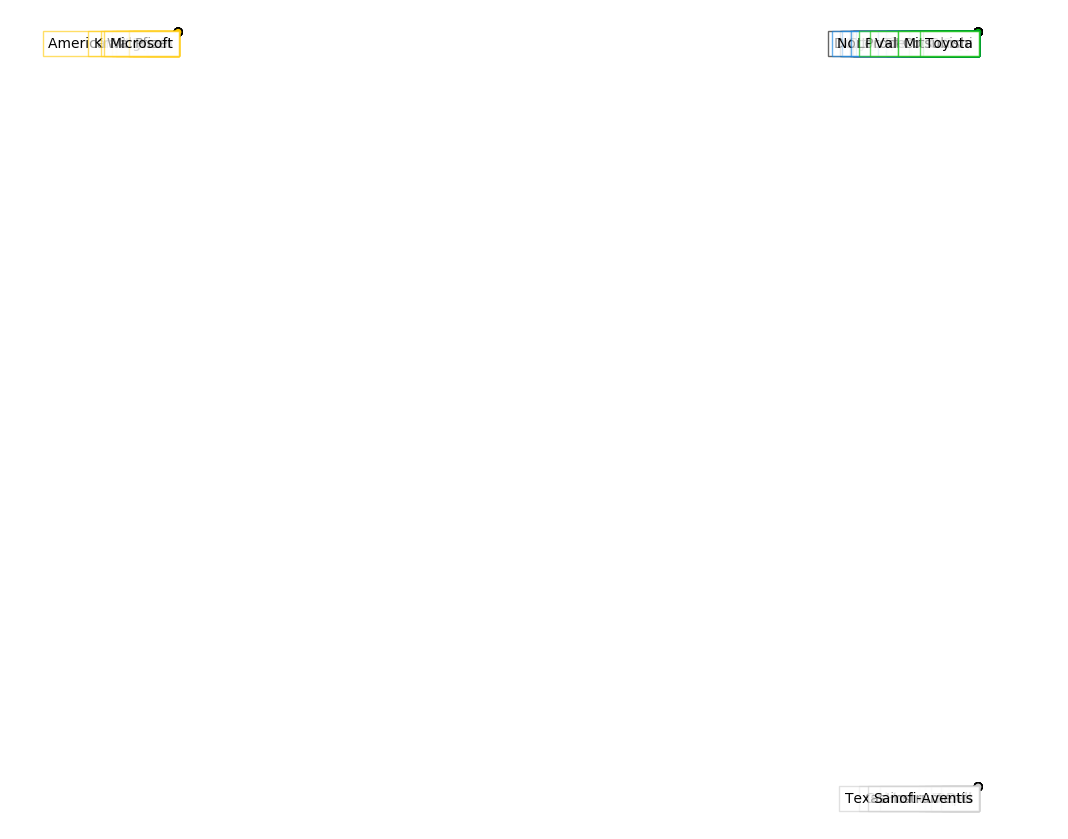

In [26]:
plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
#a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()

# TS Clustering Try #2

In [ ]:
import numpy as np;
import seaborn as sns;
import pandas as pd
from scipy import stats
import scipy.cluster.hierarchy as hac
import matplotlib.pyplot as plt

num_samples = 10
group_size = 4

x = np.linspace(0, 15, num_samples)
a = np.sin(x) + np.linspace(0, 5, num_samples)

x = np.linspace(0, 50, num_samples)
b = np.sin(x) + np.linspace(0, -8, num_samples)
c = np.sin(x + 2)

d = np.linspace(0, 14, num_samples)
e = np.random.randn(group_size, 1) + np.linspace(0, -3, num_samples)

x = np.linspace(0, 4, num_samples)
f = np.sin(x)

variances = [dflist_x.tolist()[:1000], dflist_2x.tolist()[:1000], dflist_4x.tolist()[:1000], dflist_8x.tolist()[:1000]]


timeSeries = pd.DataFrame()
ax = None

#for arr in [a,b,c,d,e,f]:
for arr in [dflist_x.tolist()[:1000], dflist_2x.tolist()[:1000], dflist_4x.tolist()[:1000], dflist_8x.tolist()[:1000]]:    
    #print(arr)
    print(np.random.rand(group_size, num_samples))
    print((np.random.randn(group_size, 1)*3))
    #arr = arr + np.random.rand(group_size, num_samples) + (np.random.randn(group_size, 1)*3)
    #print(arr)
    df = pd.DataFrame(arr)
    timeSeries = timeSeries.append(df)

    # We use seaborn to plot what we have
    #ax = sns.tsplot(ax=ax, data=df.values, ci=[68, 95])
    #ax = sns.tsplot(ax=ax, data=df.values, err_style="unit_traces")

In [ ]:
# Just one line :)
Z = hac.linkage(timeSeries, 'single', 'correlation')

# Plot the dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [ ]:
# Here we decided to use spearman correlation
correlation_matrix = timeSeries.T.corr(method='spearman')

# Do the clustering
Z = hac.linkage(correlation_matrix, 'single')

# Plot dendogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
hac.dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

### Reference:
1. [](http://scikit-learn.org/stable/modules/generated/sklearn.covariance.GraphLassoCV.html)
2. [](http://scikit-learn.org/stable/modules/covariance.html)


1. [Mining Time-series with Trillions of Points: Dynamic Time Warping at scale](http://practicalquant.blogspot.com/2012/10/mining-time-series-with-trillions-of.html)
2. [sackoverflow post](http://stackoverflow.com/questions/34940808/hierarchical-clustering-of-time-series-in-python-scipy-numpy-pandas)
3. [scilearn material](http://scikit-learn.org/stable/modules/clustering.html)
4. [pattern matching over time series data](http://stats.stackexchange.com/questions/136091/sequential-pattern-matching-in-time-series-data)

http://sklearn.lzjqsdd.com/modules/covariance.html